# Burgers equation in 1D (PINN & SPINN)

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN

In [4]:
eqx_list = (
    (eqx.nn.Linear, 2, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 1),
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="PDENonStatio"
)

Create the SPINN

In [5]:
d = 2
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),
)
key, subkey = random.split(key)
u_spinn, init_nn_params_spinn = jinns.nn.SPINN_MLP.create(
    subkey, d, r, eqx_list, "PDENonStatio"
)

Create a DataGenerator object.

In [6]:
n = 2500
nb = 200
ni = 200
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [7]:
train_data_spinn = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=5000,
    ni=ni,
    nb=nb,
    domain_batch_size=32,
    border_batch_size=32,
    initial_batch_size=32,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

Let's plot the initial condition

## Model parameters

In [ ]:
nu = jnp.array(1 / (100 * jnp.pi))

A set of parameters as required by the losses' `evaluate` functions: a particular `Params` object that we instanciate next.

In [9]:
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn, eq_params={"nu": nu}
)
init_params_spinn = jinns.parameters.Params(
    nn_params=init_nn_params_spinn, eq_params={"nu": nu}
)

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

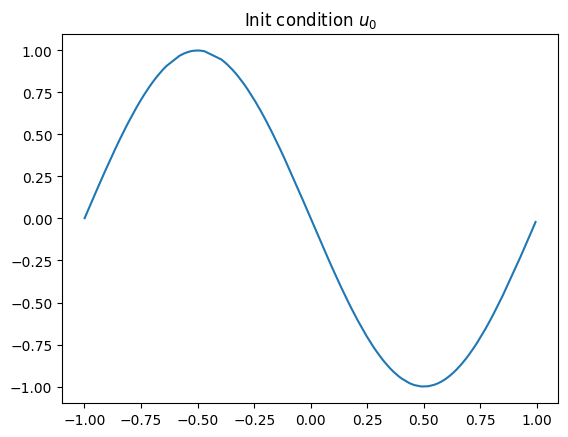

In [10]:
def u0(x):
    return -jnp.sin(jnp.pi * x)


plt.plot(
    train_data.initial.sort(axis=0), vmap(u0, (0), 0)(train_data.initial.sort(axis=0))
)
plt.title(r"Init condition $u_0$")

## Loss construction

In [11]:
be_loss = jinns.loss.BurgersEquation(Tmax=Tmax)
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=100, boundary_loss=1
)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_pinn,
)

In [12]:
import jinns.loss


loss_weights_spinn = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=10, boundary_loss=1
)

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights_spinn,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_spinn,
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [13]:
import optax

params_pinn = init_params_pinn

tx = optax.adamw(learning_rate=1e-3)
n_iter = 15000

params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params_pinn,
        data=train_data,
        optimizer=tx,
        loss=loss_pinn,
        n_iter=n_iter,
    )
)
print(total_loss_list_pinn)

Initialization time: 0.4317018985748291

Compilation took
 2.3066840171813965 

[train] Iteration 0: loss value = 49.608665466308594
[train] Iteration 1000: loss value = 0.3505711853504181
[train] Iteration 2000: loss value = 0.28137752413749695
[train] Iteration 3000: loss value = 0.256564736366272
[train] Iteration 4000: loss value = 0.23694682121276855
[train] Iteration 5000: loss value = 0.2104642689228058
[train] Iteration 6000: loss value = 0.1951574832201004
[train] Iteration 7000: loss value = 0.1553361713886261
[train] Iteration 8000: loss value = 0.05679241940379143
[train] Iteration 9000: loss value = 0.019463468343019485
[train] Iteration 10000: loss value = 0.009123600088059902
[train] Iteration 11000: loss value = 0.006047413218766451
[train] Iteration 12000: loss value = 0.006810352671891451
[train] Iteration 13000: loss value = 0.0035258508287370205
[train] Iteration 14000: loss value = 0.002348276088014245

Stopping main optimization loop, cause: max iteration is reach

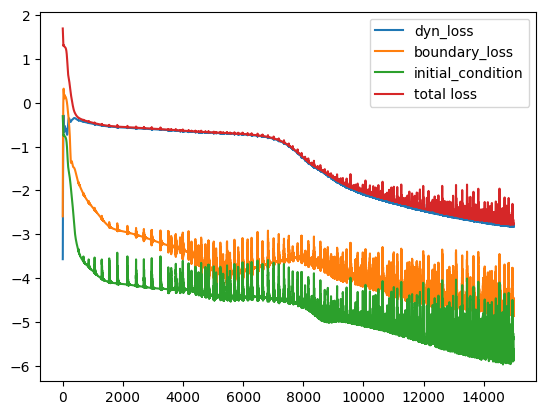

In [14]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [15]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

(<Figure size 500x500 with 2 Axes>, <Axes: title={'center': 'u(t, x)'}>)

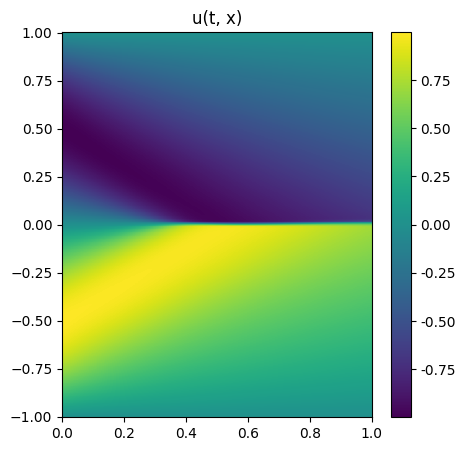

In [16]:
u_est_pinn = lambda t_x: u_pinn(t_x, params_pinn)
# same subkey
jinns.plot.plot1d_image(
    u_est_pinn,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=(5, 5),
    title="u(t, x)",
)

<Axes: xlabel='x', ylabel='$u(t_i, x)$'>

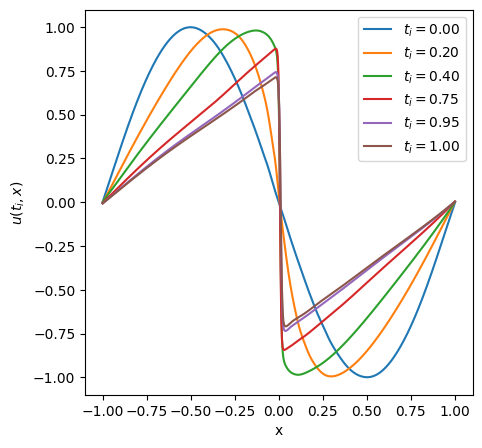

In [17]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.0]
jinns.plot.plot1d_slice(
    u_est_pinn, xdata=val_xdata, time_slices=time_slices, figsize=(5, 5)
)

### Train the SPINN and plot loss values and solution

In [18]:
params_spinn = init_params_spinn

tx = optax.adamw(learning_rate=1e-4)
n_iter = 30000
(
    params_spinn,
    total_loss_list_spinn,
    loss_by_term_dict_spinn,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=params_spinn,
    data=train_data_spinn,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter,
)
print(total_loss_list_spinn)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/loss/_DynamicLossAbstract.py:156: UserWarning: Return value from DynamicLoss' equation has more than one dimension. This is in general a mistake (probably from an unfortunate broadcast in jnp.array computations) resulting in bad reduction operations in losses.
  warnings.warn(


Initialization time: 3.20224928855896

Compilation took
 6.989004611968994 

[train] Iteration 0: loss value = 5.443758487701416
[train] Iteration 1000: loss value = 0.4303569197654724
[train] Iteration 2000: loss value = 0.28314149379730225
[train] Iteration 3000: loss value = 0.3230310380458832
[train] Iteration 4000: loss value = 0.3244369626045227
[train] Iteration 5000: loss value = 0.31237661838531494
[train] Iteration 6000: loss value = 0.30165305733680725
[train] Iteration 7000: loss value = 0.1922120749950409
[train] Iteration 8000: loss value = 0.2761506140232086
[train] Iteration 9000: loss value = 0.319647878408432
[train] Iteration 10000: loss value = 0.20497091114521027
[train] Iteration 11000: loss value = 0.19971996545791626
[train] Iteration 12000: loss value = 0.23592185974121094
[train] Iteration 13000: loss value = 0.26274242997169495
[train] Iteration 14000: loss value = 0.27902206778526306
[train] Iteration 15000: loss value = 0.24346035718917847
[train] Iteration

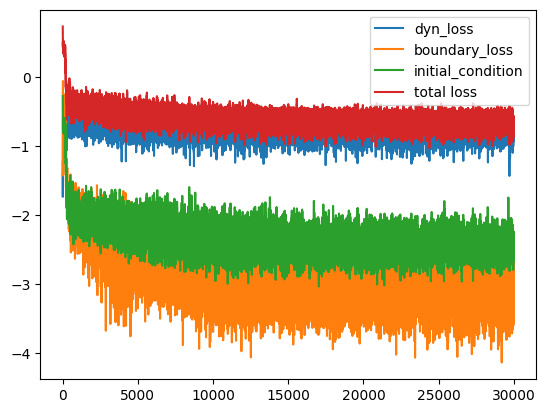

In [19]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

(<Figure size 500x500 with 2 Axes>, <Axes: title={'center': 'u(t, x)'}>)

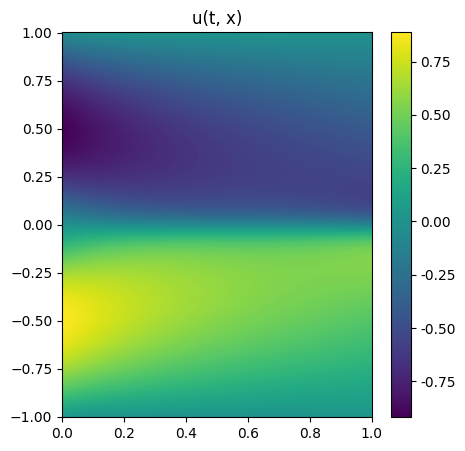

In [20]:
u_est_spinn = lambda t_x: u_spinn(t_x, params_spinn)

jinns.plot.plot1d_image(
    u_est_spinn,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=(5, 5),
    title="u(t, x)",
    spinn=True,
)

<Axes: xlabel='x', ylabel='$u(t_i, x)$'>

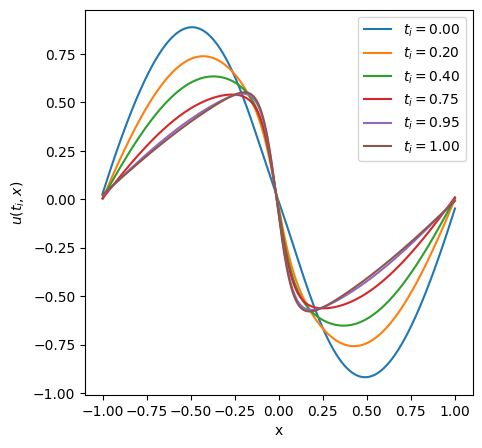

: 

In [ ]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.0]
jinns.plot.plot1d_slice(
    u_est_spinn, xdata=val_xdata, time_slices=time_slices, spinn=True, figsize=(5, 5)
)

## Conclusion

We have been able to solve the Burgers PDE with jinns both with a PINN and SPINN. The PINN solution looks more accurate and is obtained faster than the SPINN solution.
One could still improve the solutions by tuning the network architecture and batch size as we here used default parameters.